
# XGBoost + Optuna Pipeline
This notebook builds and evaluates XGBoost models with Optuna hyperparameter optimization over multiple time-based folds.

## 1. Imports and Setup

In [17]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, ConstantInputWarning
import optuna
from tqdm import tqdm
import joblib
import pickle
from pathlib import Path
import warnings
from IPython.display import display
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging and warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore', category=ConstantInputWarning)
pd.set_option('future.no_silent_downcasting', True)

## 2. Configuration

In [27]:
class Config:
    MONTHS = ['2019-04', '2019-10', '2020-04', '2020-10']
    FOLDS = range(1, 6)
    SELECTED_FEATURES = [
        'ROW', 'COL', 'TCW', 'R250', 'R500', 'R850', 'U850',
        'V850', 'EWSS', 'KX', 'CAPE', 'SSHF', 'PEV', 'TCLW'
    ]
    TARGET = 'AWS'
    CSI_THRESHOLD = 0.1
    OPTUNA_TRIALS = 50
    RANDOM_STATE = 42
    N_JOBS = -1
    BASE_DATA_PATH = Path('/kaggle/input/ai-dataknnimputedataset-k-fold')
    CACHE_DIR = Path('./cachedir')
    OUTPUT_DIR = Path('/kaggle/working')
    METRICS = ['RMSE', 'Pearson R', 'Bias', 'CSI', 'MCC']
    SAVE_PREDICTIONS = True
    SAVE_VALIDATION_PREDICTIONS = False
    LAG_STEPS = [1, 2]
    WINDOW_SIZES = [3, 6]
    PREDICT_STEP = 3
    USE_LAG_FEATURES = True
    USE_ROLLING_STATISTICS = True

# Set up caching
memory = joblib.Memory(location=Config.CACHE_DIR, verbose=0)

## 3. Utility Functions

In [19]:
def compute_csi(y_true, y_pred, threshold):
    y_true_event = y_true >= threshold
    y_pred_event = y_pred >= threshold
    tp = np.sum(y_true_event & y_pred_event)
    fp = np.sum(~y_true_event & y_pred_event)
    fn = np.sum(y_true_event & ~y_pred_event)
    denom = tp + fp + fn
    return tp / denom if denom != 0 else 0.0

def compute_mcc(y_true, y_pred, threshold):
    y_true_event = y_true >= threshold
    y_pred_event = y_pred >= threshold

    tp = np.sum(y_true_event & y_pred_event)
    tn = np.sum(~y_true_event & ~y_pred_event)
    fp = np.sum(~y_true_event & y_pred_event)
    fn = np.sum(y_true_event & ~y_pred_event)

    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / denominator if denominator != 0 else 0.0
    


def save_predictions(month, fold, y_true, y_pred, dataset_type, location_data=None):
    if dataset_type == 'val' and not Config.SAVE_VALIDATION_PREDICTIONS:
        return
    if not Config.SAVE_PREDICTIONS:
        return

    pred_dir = Config.OUTPUT_DIR / 'predictions'
    pred_dir.mkdir(exist_ok=True)

    # Create column names for each prediction step
    pred_cols = [f"pred_+{i}h" for i in range(Config.PREDICT_STEP)]
    true_cols = [f"true_+{i}h" for i in range(Config.PREDICT_STEP)]

    # Create a DataFrame with all prediction steps
    pred_df = pd.DataFrame(y_pred, columns=pred_cols)
    for i, col in enumerate(true_cols):
        pred_df[col] = y_true[:, i]

    # Add location data if provided
    if location_data is not None:
        for col in ['ROW', 'COL']:
            if col in location_data.columns:
                pred_df[col] = location_data[col].values

    # Save file
    filename = pred_dir / f"{month}_fold{fold}_{dataset_type}_predictions.csv"
    pred_df.to_csv(filename, index=False)




def check_predictions_variability(model, X, y, threshold=1e-6):
    preds = model.predict(X)
    return np.std(preds) > threshold


def analyze_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {feature_names[i]: importances[i] for i in indices}


def display_feature_importance(all_models, feature_names):
    all_importances = {}
    for month, model in all_models.items():
        for i, feat in enumerate(feature_names):
            all_importances.setdefault(feat, []).append(model.feature_importances_[i])
    avg_importances = {f: np.mean(v) for f, v in all_importances.items()}
    return avg_importances

## 4. Feature Engineering Functions

In [20]:
def create_lag_features(train_df, val_test_df, target_col, lag_steps=[1, 2, 3], group_cols=['ROW', 'COL']):
    train_copy = train_df.copy()
    val_test_copy = val_test_df.copy()

    if 'DATETIME' in train_copy.columns:
        train_copy['DATETIME'] = pd.to_datetime(train_copy['DATETIME'])
    if 'DATETIME' in val_test_copy.columns:
        val_test_copy['DATETIME'] = pd.to_datetime(val_test_copy['DATETIME'])

    if 'DATETIME' in train_copy.columns:
        train_copy = train_copy.sort_values(by=group_cols + ['DATETIME'])
    if 'DATETIME' in val_test_copy.columns:
        val_test_copy = val_test_copy.sort_values(by=group_cols + ['DATETIME'])

    for lag in lag_steps:
        col_name = f'{target_col}_lag{lag}' if lag > 0 else f'{target_col}_future{abs(lag)}'
        if len(group_cols) > 0:
            train_copy[col_name] = train_copy.groupby(group_cols)[target_col].shift(lag)
        else:
            train_copy[col_name] = train_copy[target_col].shift(lag)

    combined_dfs = []

    for group_vals, group_df in val_test_copy.groupby(group_cols):
        group_filter = dict(zip(group_cols, group_vals)) if isinstance(group_vals, tuple) else {group_cols[0]: group_vals}

        history_df = train_copy
        for col, val in group_filter.items():
            history_df = history_df[history_df[col] == val]

        if 'DATETIME' in group_df.columns and 'DATETIME' in history_df.columns:
            if not history_df.empty:
                latest_history_time = history_df['DATETIME'].max()
                valid_history = history_df[history_df['DATETIME'] < group_df['DATETIME'].min()]
                combined_df = pd.concat([valid_history, group_df]).sort_values(by='DATETIME')
            else:
                combined_df = group_df.copy()
        else:
            combined_df = pd.concat([history_df, group_df])

        for lag in lag_steps:
            col_name = f'{target_col}_lag{lag}' if lag > 0 else f'{target_col}_future{abs(lag)}'
            combined_df[col_name] = combined_df[target_col].shift(lag)

        if 'DATETIME' in group_df.columns:
            result_df = combined_df[combined_df['DATETIME'].isin(group_df['DATETIME'])]
        else:
            result_df = combined_df.tail(len(group_df))

        combined_dfs.append(result_df)

    return pd.concat(combined_dfs) if combined_dfs else val_test_copy

def create_rolling_statistics(train_df, val_test_df, target_col, window_sizes=[3, 6], group_cols=['ROW', 'COL']):
    """
    Creates rolling window statistics (mean, std) for the target column.
    Applies .shift(1) after calculation to prevent data leakage, ensuring
    features for time t only use data up to t-1.
    """
    train_copy = train_df.copy()
    val_test_copy = val_test_df.copy()

    # Ensure DATETIME column exists and is sorted
    if 'DATETIME' not in train_copy.columns or 'DATETIME' not in val_test_copy.columns:
        print("Warning: DATETIME column not found. Skipping rolling statistics.")
        return val_test_copy # Return original df if no datetime

    train_copy['DATETIME'] = pd.to_datetime(train_copy['DATETIME'])
    val_test_copy['DATETIME'] = pd.to_datetime(val_test_copy['DATETIME'])
    train_copy = train_copy.sort_values(by=group_cols + ['DATETIME'])
    val_test_copy = val_test_copy.sort_values(by=group_cols + ['DATETIME'])

    # --- Pre-calculate shifted rolling stats on training data ---
    # This helps provide history for the first few points in val_test_df
    # Applying shift(1) here too for consistency and correctness within training history.
    for window in window_sizes:
        roll_mean_col = f'{target_col}_rollmean_{window}'
        roll_std_col = f'{target_col}_rollstd_{window}'

        # Calculate rolling stats (includes current point t)
        train_copy[roll_mean_col] = train_copy.groupby(group_cols)[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        train_copy[roll_std_col] = train_copy.groupby(group_cols)[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

        # Shift the results by 1 within each group to avoid lookahead bias
        if Config.PREDICT_STEP == 0:
            train_copy[roll_mean_col] = train_copy.groupby(group_cols)[roll_mean_col].shift(1)
            train_copy[roll_std_col] = train_copy.groupby(group_cols)[roll_std_col].shift(1)
    # ----------------------------------------------------------

    combined_dfs = [] # To store results for each group

    # Iterate through each group (e.g., each location) in the validation/test set
    for group_vals, group_df in val_test_copy.groupby(group_cols):
        # Create a filter dictionary for the current group
        group_filter = dict(zip(group_cols, group_vals)) if isinstance(group_vals, tuple) else {group_cols[0]: group_vals}

        # Find the relevant historical data for this group from the (modified) training set
        history_df = train_copy
        for col, val in group_filter.items():
            history_df = history_df[history_df[col] == val] # Filter by group values

        # Combine historical data (before the current group's start time) and current group data
        if not history_df.empty:
            # Only use history strictly before the current group's first timestamp
            valid_history = history_df[history_df['DATETIME'] < group_df['DATETIME'].min()]
            # Concatenate valid history with the current group's data
            combined_df = pd.concat([valid_history, group_df], ignore_index=True).sort_values(by='DATETIME')
        else:
            # If no history for this group, just use the group's data
            combined_df = group_df.copy().sort_values(by='DATETIME')

        # Calculate rolling statistics on the combined data, then shift
        for window in window_sizes:
            roll_mean_col = f'{target_col}_rollmean_{window}'
            roll_std_col = f'{target_col}_rollstd_{window}'

            # Calculate rolling stats (this calculation still includes point t)
            combined_df[roll_mean_col] = combined_df[target_col].rolling(
                window=window, min_periods=1).mean()
            combined_df[roll_std_col] = combined_df[target_col].rolling(
                window=window, min_periods=1).std()

            # *** THE FIX: Shift the results by 1 ***
            # This ensures the feature at row t uses data only up to t-1
            if Config.PREDICT_STEP == 0:
                combined_df[roll_mean_col] = combined_df[roll_mean_col].shift(1)
                combined_df[roll_std_col] = combined_df[roll_std_col].shift(1)
            # ***************************************

        # Filter the combined dataframe to get only the rows corresponding to the original val/test group
        # These rows now have the correctly shifted rolling features
        result_df = combined_df[combined_df['DATETIME'].isin(group_df['DATETIME'])].copy() # Use .copy() to avoid SettingWithCopyWarning later
        combined_dfs.append(result_df)

    # Concatenate results from all groups and sort one last time
    if combined_dfs:
        final_df = pd.concat(combined_dfs).sort_values(by=group_cols + ['DATETIME'])
        # Ensure the index is unique if needed, though sorting usually handles it
        final_df = final_df.reset_index(drop=True)
        return final_df
    else:
        # If val_test_copy was empty or had no groups, return the original (potentially empty) copy
        return val_test_copy

def handle_missing_values(df, lag_steps, window_sizes):
    """Handle missing values without chained assignment warnings or downcasting issues."""
    df = df.copy()

    # Replace infinities without inplace to avoid downcasting warning
    df = df.replace([np.inf, -np.inf], np.nan)

    lag_roll_cols = [
        col for col in df.columns
        if (Config.USE_LAG_FEATURES and any(col.endswith(f"_lag{lag}") for lag in lag_steps)) or
           (Config.USE_ROLLING_STATISTICS and any(col.endswith(f"_rollmean_{window}") for window in window_sizes)) or
           (Config.USE_ROLLING_STATISTICS and any(col.endswith(f"_rollstd_{window}") for window in window_sizes))
    ]

    if lag_roll_cols:
        df[lag_roll_cols] = df[lag_roll_cols].fillna(0)

    return df

## 5. Data Loading and Processing

In [21]:
@memory.cache
def load_and_process_data(train_path, val_test_path, selected_features, lag_steps=[1, 2, 3],
                            window_sizes=[3, 7], is_test=False):
    try:
        train_df = pd.read_csv(train_path)
        val_test_df = pd.read_csv(val_test_path)
    except FileNotFoundError:
        raise ValueError(f"Data file not found")

    target_cols = []
    for step in range(1, Config.PREDICT_STEP + 1):
        future_col = f"{Config.TARGET}_future{step}"
        target_cols.append(future_col)
        for df in [train_df, val_test_df]:
            df[future_col] = df.groupby(['ROW', 'COL'])[Config.TARGET].shift(-step)

    if Config.USE_LAG_FEATURES:
        val_test_with_lags = create_lag_features(train_df, val_test_df, Config.TARGET, lag_steps, ['ROW', 'COL'])
    else:
        val_test_with_lags = val_test_df.copy()

    if Config.USE_ROLLING_STATISTICS:
        val_test_with_features = create_rolling_statistics(train_df, val_test_with_lags, Config.TARGET, window_sizes, ['ROW', 'COL'])
    else:
        val_test_with_features = val_test_with_lags.copy()


    if Config.USE_LAG_FEATURES:
        for lag in lag_steps:
            train_df[f'{Config.TARGET}_lag{lag}'] = train_df.groupby(['ROW', 'COL'])[Config.TARGET].shift(lag)

    if Config.USE_ROLLING_STATISTICS:
        for window in window_sizes:
            train_df[f'{Config.TARGET}_rollmean_{window}'] = train_df.groupby(['ROW', 'COL'])[Config.TARGET].transform(
                lambda x: x.rolling(window, min_periods=1).mean())
            train_df[f'{Config.TARGET}_rollstd_{window}'] = train_df.groupby(['ROW', 'COL'])[Config.TARGET].transform(
                lambda x: x.rolling(window, min_periods=1).std())
        

    train_df = train_df.drop(columns=['DATETIME'], errors='ignore')
    val_test_with_features = val_test_with_features.drop(columns=['DATETIME'], errors='ignore')

    train_df = handle_missing_values(train_df, lag_steps, window_sizes)
    val_test_with_features = handle_missing_values(val_test_with_features, lag_steps, window_sizes)

    train_df.dropna(subset=target_cols, inplace=True)
    val_test_with_features.dropna(subset=target_cols, inplace=True)

    # Identify features
    feature_cols = [col for col in train_df.columns
                    if col not in target_cols and
                    (col in selected_features or
                     (Config.USE_LAG_FEATURES and any(col.endswith(f"_lag{lag}") for lag in lag_steps)) or
                     (Config.USE_ROLLING_STATISTICS and any(col.endswith(f"_rollmean_{window}") for window in window_sizes)) or
                     (Config.USE_ROLLING_STATISTICS and any(col.endswith(f"_rollstd_{window}") for window in window_sizes)) or
                     (Config.PREDICT_STEP > 0 and col == Config.TARGET))]


    # Return data
    if is_test:
        return (
            train_df[feature_cols].values if len(train_df) > 0 else np.zeros((0, len(feature_cols))),
            val_test_with_features[feature_cols].values if len(val_test_with_features) > 0 else np.zeros((0, len(feature_cols))),
            train_df[target_cols].values if len(train_df) > 0 else np.zeros(0),
            val_test_with_features[target_cols].values if len(val_test_with_features) > 0 else np.zeros(0),
            feature_cols,
            val_test_with_features
        )
    else:
        return (
            train_df[feature_cols].values if len(train_df) > 0 else np.zeros((0, len(feature_cols))),
            val_test_with_features[feature_cols].values if len(val_test_with_features) > 0 else np.zeros((0, len(feature_cols))),
            train_df[target_cols].values if len(train_df) > 0 else np.zeros(0),
            val_test_with_features[target_cols].values if len(val_test_with_features) > 0 else np.zeros(0),
            feature_cols
        )

@memory.cache
def get_all_data_enhanced(selected_features, lag_steps=[1, 2, 3], window_sizes=[3, 7]):
    datasets = {}
    feature_names = None

    for month in Config.MONTHS:
        for fold in Config.FOLDS:
            key = f"{month}_fold{fold}"
            train_path = Config.BASE_DATA_PATH/month/f'fold_{fold}'/'processed_train.csv'
            val_path = Config.BASE_DATA_PATH/month/f'fold_{fold}'/'processed_val.csv'

            X_train, X_val, y_train, y_val, features = load_and_process_data(
                train_path, val_path, selected_features, lag_steps, window_sizes
            )
            

            if feature_names is None:
                feature_names = features

            datasets[key] = (X_train, X_val, y_train, y_val)

    return datasets, feature_names

## 6. Model Definition & Optimization

In [22]:
def is_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except ImportError:
        return False

def create_model(trial):
    if is_gpu_available():
        tree_method = "gpu-hist"
    else:
        tree_method = "hist"

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("lambda", 1e-5, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "tree_method": tree_method,
        "random_state": Config.RANDOM_STATE,
        "n_jobs": Config.N_JOBS,
    }

    base_model = XGBRegressor(**params)
    return MultiOutputRegressor(base_model)


def optimize_month(month, data, feature_names):
    def objective(trial):
        fold_scores = []
        for fold in Config.FOLDS:
            X_train, X_val, y_train, y_val = data[f"{month}_fold{fold}"]
            # Ensure y_train and y_val are 2D: shape (n_samples, n_targets)
            if y_train.ndim == 1:
                y_train = y_train.reshape(-1, 1)
            if y_val.ndim == 1:
                y_val = y_val.reshape(-1, 1)

            if X_val.shape[0] == 0:
                print(f"→  Skipping {month} fold {fold}: no val rows")
                continue
            model = create_model(trial)
            model.fit(X_train, y_train)

            if not check_predictions_variability(model, X_val, y_val):
                print(f"Warning: Low prediction variability in {month} fold {fold}")

            preds = model.predict(X_val)
            fold_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
        #return np.mean(fold_scores)
        if not fold_scores:
            raise optuna.TrialPruned(f"{month}: 0 valid folds")
        return float(np.mean(fold_scores))

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=Config.RANDOM_STATE))

    with tqdm(total=Config.OPTUNA_TRIALS, desc=f"Optimizing {month}") as pbar:
        def update_pbar(study, trial):
            pbar.update(1)
            pbar.set_postfix({"Best RMSE": study.best_value})
        study.optimize(objective, n_trials=Config.OPTUNA_TRIALS, n_jobs=Config.N_JOBS, callbacks=[update_pbar])

    performance = []
    best_params = study.best_params
    print(f"\nBest parameters for {month}: {best_params}")

    for fold in Config.FOLDS:
        X_train, X_val, y_train, y_val = data[f"{month}_fold{fold}"]
        # Ensure y_train and y_val are 2D: shape (n_samples, n_targets)
        if y_train.ndim == 1:
            y_train = y_train.reshape(-1, 1)
        if y_val.ndim == 1:
            y_val = y_val.reshape(-1, 1)

        if X_val.shape[0] == 0:
                print(f"→  Skipping performance eval for {month} fold {fold}: no val rows")
                continue
        base_model = XGBRegressor(**best_params, n_jobs=2, random_state=Config.RANDOM_STATE)
        model = MultiOutputRegressor(base_model)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        preds = np.clip(preds, 0, None)

        rmse = np.sqrt(mean_squared_error(y_val, preds))
        pearson = np.mean([pearsonr(y_val[:, i], preds[:, i])[0] for i in range(y_val.shape[1])])
        bias = np.mean(preds - y_val)
        csi = np.mean([compute_csi(y_val[:, i], preds[:, i], Config.CSI_THRESHOLD) for i in range(y_val.shape[1])])
        mcc = np.mean([compute_mcc(y_val[:, i], preds[:, i], Config.CSI_THRESHOLD) for i in range(y_val.shape[1])])

        performance.append({
            'Month': month,
            'Fold': fold,
            'RMSE': rmse,
            'Pearson R': pearson,
            'Bias': bias,
            'CSI': csi,
            'MCC': mcc
        })

    return best_params, pd.DataFrame(performance)

## 7. Training

In [29]:
Config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
Config.CACHE_DIR.mkdir(parents=True, exist_ok=True)

selected_features = Config.SELECTED_FEATURES
print(f"Using features: {selected_features}")

full_data, feature_names = get_all_data_enhanced(selected_features, Config.LAG_STEPS, Config.WINDOW_SIZES)
print(f"\nFinal features (including generated): {feature_names}")

best_params = {}
cv_results = []
final_models = {}

for month in Config.MONTHS:
    params, metrics = optimize_month(month, full_data, feature_names)
    best_params[month] = params
    cv_results.append(metrics)

    print(f"\nTraining final model for {month}")
    X_train, X_val, y_train, y_val = full_data[f"{month}_fold5"]
    model = XGBRegressor(
        **params,
        n_jobs=Config.N_JOBS,
        random_state=Config.RANDOM_STATE
    )
    model.fit(np.vstack([X_train, X_val]), np.concatenate([y_train, y_val]))
    final_models[month] = model

final_metrics = []
for month in Config.MONTHS:
    print(f"\nEvaluating {month} on test data")
    train_path = Config.BASE_DATA_PATH/month/f'fold_5'/'processed_train.csv'
    val_path = Config.BASE_DATA_PATH/month/f'fold_5'/'processed_val.csv'
    test_path = Config.BASE_DATA_PATH/month/'fold_5'/'merged_test.csv'

    if not os.path.exists(test_path):
        print(f"Test file not found: {test_path}")
        continue

    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    combined_train = pd.concat([train_df, val_df]).sort_values(['ROW', 'COL', 'DATETIME'])

    temp_combined_path = Config.CACHE_DIR / f"{month}_combined_train_val.csv"
    combined_train.to_csv(temp_combined_path, index=False)

    _, X_test, _, y_test, _, test_df = load_and_process_data(
        temp_combined_path, test_path, selected_features,
        Config.LAG_STEPS, Config.WINDOW_SIZES, is_test=True
    )

    if len(X_test) == 0:
        print(f"Warning: No test samples remaining after preprocessing for {month}")
        continue

    preds = final_models[month].predict(X_test)
    preds = np.clip(preds, 0, None)
    std_dev = np.std(preds)
    # print(f"Test prediction standard deviation: {std_dev:.6f}")

    save_predictions(month, 5, y_test, preds, 'test', test_df)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    pearson = np.mean([pearsonr(y_test[:, i], preds[:, i])[0] for i in range(y_test.shape[1])])
    bias = np.mean(preds - y_test)
    csi = np.mean([compute_csi(y_test[:, i], preds[:, i], Config.CSI_THRESHOLD) for i in range(y_test.shape[1])])
    mcc = np.mean([compute_mcc(y_test[:, i], preds[:, i], Config.CSI_THRESHOLD) for i in range(y_test.shape[1])])

    final_metrics.append({
        'Month': month,
        'RMSE': rmse,
        'Pearson R': pearson,
        'Bias': bias,
        'CSI': csi,
        'MCC': mcc
    })

feature_importance = display_feature_importance(final_models, feature_names)
final_results = pd.DataFrame(final_metrics)

# Calculate overall average metrics
overall_metrics = final_results[Config.METRICS].mean().round(4)
overall_metrics['Month'] = 'Overall'
final_results = pd.concat([final_results, pd.DataFrame([overall_metrics])], ignore_index=True)

filename = f"{Config.BASE_DATA_PATH.name}_random_forest_performance.csv"
final_results.to_csv(Config.OUTPUT_DIR / filename, index=False)

with open(Config.OUTPUT_DIR / 'final_models.pkl', 'wb') as f:
    pickle.dump({
        'models': final_models,
        'best_params': best_params,
        'features': feature_names,
        'cv_results': cv_results,
        'final_results': final_results,
        'feature_importance': feature_importance
    }, f)

Using features: ['ROW', 'COL', 'TCW', 'R250', 'R500', 'R850', 'U850', 'V850', 'EWSS', 'KX', 'CAPE', 'SSHF', 'PEV', 'TCLW']

Final features (including generated): ['ROW', 'COL', 'AWS', 'CAPE', 'EWSS', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SSHF', 'TCLW', 'TCW', 'U850', 'V850', 'AWS_lag1', 'AWS_lag2', 'AWS_rollmean_3', 'AWS_rollstd_3', 'AWS_rollmean_6', 'AWS_rollstd_6']


Optimizing 2019-04: 100%|██████████| 1/1 [00:34<00:00, 34.04s/it, Best RMSE=0.623]



Best parameters for 2019-04: {'n_estimators': 316, 'max_depth': 7, 'min_child_weight': 9.805834400123326, 'gamma': 0.8913363166440891, 'lambda': 7.026279339075813, 'subsample': 0.5336768894199206, 'colsample_bytree': 0.703337708767779, 'learning_rate': 0.22118482802832964}

Training final model for 2019-04

Evaluating 2019-04 on test data


## 8. Display Results


=== Cross-Validation Summary ===


,RMSE,Pearson R,Bias,CSI,MCC
Month,,,,,
2019-04,0.6147,0.1208,0.1611,0.1594,0.168



=== Final Test Summary ===


,Month,RMSE,Pearson R,Bias,CSI,MCC
0,2019-04,1.147104,0.126689,-0.022346,0.111039,0.130594
1,Overall,1.147100,0.126700,-0.022300,0.111000,0.130600


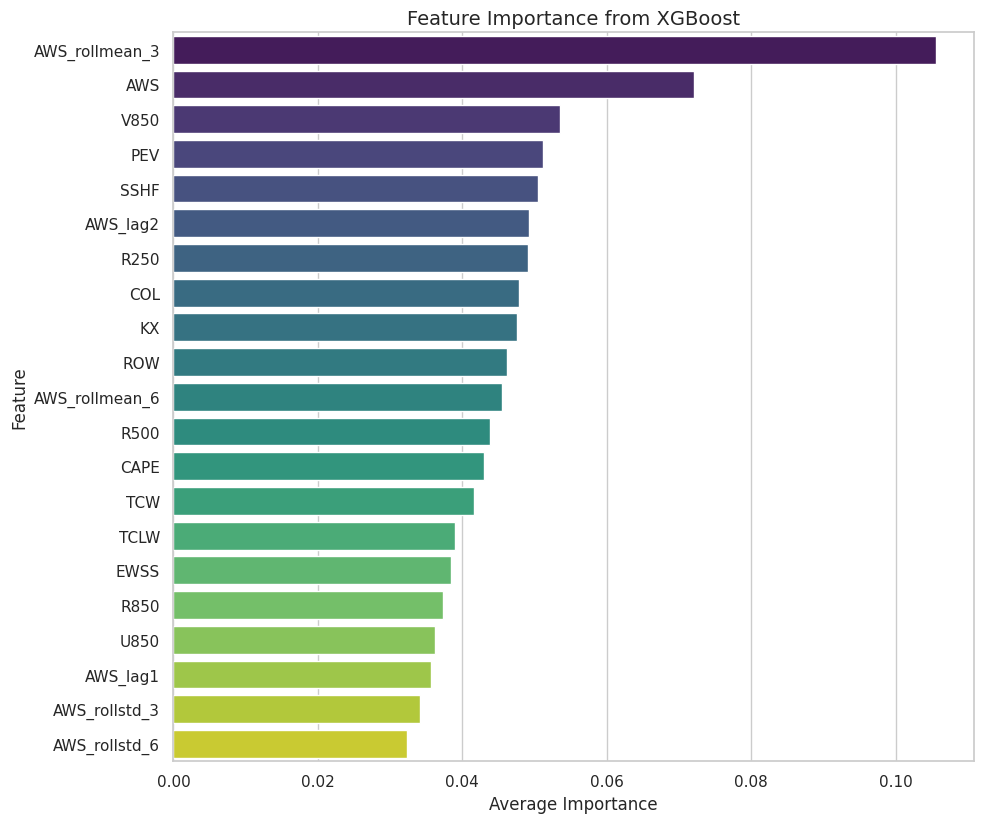

In [30]:
print("\n=== Cross-Validation Summary ===")

cv_results_df = pd.concat(cv_results, ignore_index=True)
display(cv_results_df.groupby('Month')[Config.METRICS].mean().round(4))

print("\n=== Final Test Summary ===")
display(final_results)

# Plot feature importance using Seaborn
sorted_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
features = [item[0] for item in sorted_importance]
importance_values = [item[1] for item in sorted_importance]

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importance_values
})

plt.figure(figsize=(10, max(6, len(features) * 0.4)))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=importance_df,
    y="Feature",
    x="Importance",
    palette="viridis"
)
ax.set_title("Feature Importance from XGBoost", fontsize=14)
ax.set_xlabel("Average Importance", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / 'feature_importance.png')
plt.show()